## Assignment 2 (Part 1): Classifying if cell images are cancerous or not

<i> By Akshita Agrawal (s3933878) and Penusha Udapamunuwa (s3925899) </i>

## Table of Contents

* [Introduction](#intro)
* [EDA](#eda)
* [Loading Images](#dataprep)
* [Data splitting](#datasplit)
* [Evaluation Framework](#ef)
* [Baseline Model](#base)
* [Regularization](#reg)
* [Testing](#test)

## Introduction <a id='intro'></a>

This assignment contains two parts. This part will be where we use machine learning techniques to predict if the given cell images are cancerous or not.

## Explaratory Data Analysis <a id="eda"> </a>

First we will load in our dataset and explore its contents

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
df = pd.read_csv('../Image_classification_data/data_labels_mainData.csv', delimiter=',')
df.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [3]:
df.shape

(9896, 6)

This dataset contains 6 columns and 9896 rows. Now we will take a look at the number of unique values in each column

In [4]:
df.nunique()

InstanceID      9896
patientID         60
ImageName       9896
cellTypeName       4
cellType           4
isCancerous        2
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


It is observed that `patientID`, `cellTypeName`, `cellType`, and `isCancerous` are catergorical attribtues. Since we are looking at building a model that predicts if an image is cancerous or not, `patientID` and `InstanceID` do not have useful information for the modelling task at hand, but `ImageName` is needed for this classification. Therefore, we will remove `InstanceID` and `patientID` from this dataset.

In [6]:
df = df.drop(['InstanceID','patientID'], axis=1)
df.head()

,ImageName,cellTypeName,cellType,isCancerous
0,22405.png,fibroblast,0,0
1,22406.png,fibroblast,0,0
2,22407.png,fibroblast,0,0
3,22408.png,fibroblast,0,0
4,22409.png,fibroblast,0,0


For this part of the assignment we only need `ImageName` and `isCancerous` columns. Therfore we will drop all other columns.

In [7]:
df = df.drop(['cellType', 'cellTypeName'],axis=1)
df.head()

,ImageName,isCancerous
0,22405.png,0
1,22406.png,0
2,22407.png,0
3,22408.png,0
4,22409.png,0


We will take a look at how the data is distributed in the `isCancerous` using a bar chart

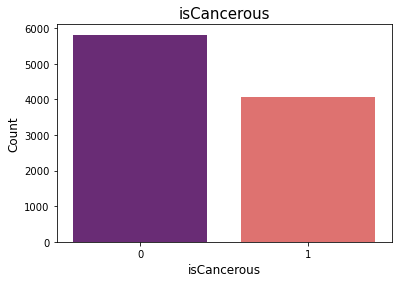

In [8]:
import seaborn as sns
figsize=(20, 7)

sns.countplot(x='isCancerous', data=df, palette='magma', order=df['isCancerous'].value_counts().index)
plt.title('isCancerous', fontsize=15)
plt.xlabel('isCancerous', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.show()

There are more non-cancerous cell images compared to cancerous cell images in this dataset. 

## Data Pre-processing <a id=dataprep></a>

We will be using image classification when building our machine learning model. Our images are stored in the folder "./Image_classification_data/patch_images". The image name of these images correspond with `ImageName` in our dateset. We will append a new column, `ImgPath` with the corresponding `ImageName` to the dataset as we need to get the images from the relevant folder.

In [9]:
df['ImgPath'] = '../Image_classification_data/patch_images/' + df['ImageName']
df.head()

,ImageName,isCancerous,ImgPath
0,22405.png,0,../Image_classification_data/patch_images/2240...
1,22406.png,0,../Image_classification_data/patch_images/2240...
2,22407.png,0,../Image_classification_data/patch_images/2240...
3,22408.png,0,../Image_classification_data/patch_images/2240...
4,22409.png,0,../Image_classification_data/patch_images/2240...


Next we will display four random images from the dataset to see if `ImgPath` corresponds with the images

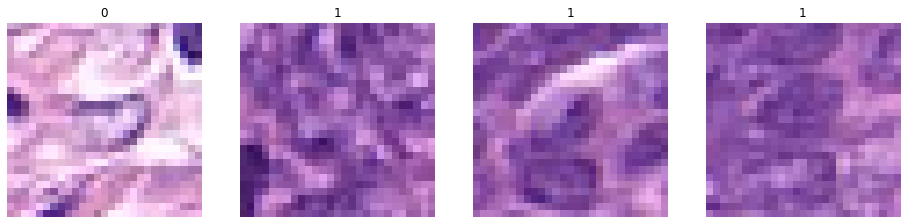

In [10]:
# Code taken from week9 QandA
from PIL import Image
r_inx = np.random.choice(9896, 4)
rand_data = df.loc[r_inx,'ImgPath']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,4,i+1)
    plt.title(df.iloc[r_inx[i]]['isCancerous'])
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show()

### Data Splitting <a id='datasplit'></a>

Next, we will split our data into train, validation and test datasets. We will be using a 60/20/20 split.

In [11]:
# Code taken from Week08 lab

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))


Train data : 5937, Val Data: 1979, Test Data: 1980


We will now create data generators for each split.

In [12]:
# Code taken from Week08 lab
train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="ImgPath",
        y_col="isCancerous",
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="ImgPath",
        y_col="isCancerous",
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 2 classes.
Found 1979 validated image filenames belonging to 2 classes.


## Evaluation Metrics <a id='ef'></a>

As observed from the EDA, `isCancerous` has 2 categories and the data in each was not evenly distributed. Therefore, we decided to use the F1 score as it provides the mean between recall and precision where precision measures the proportion of true positives over the total number of predicted positives, while recall measures the proportion of true positives over the total number of actual positives.

We predefined a class that calculates the precision and recall then calculates the F1 score.

In [13]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        f1_score = 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
        return f1_score

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

## Basline Model <a id='base'></a>

For our baseline model, we have decided to implement a Convolutional Neural Network as it uses sparse connectivity between layers, which reduces the number of parameters required to train the model and reduces overfitting. It also learns hierarchical features from raw pixels and they can be used for a wide variety of image-related tasks, such as image recognition, image segmentation, and image generation. This is ideal for us as we are using cell images to classify wether they are cancerous or not.

We will first define a function that plot the graphs of loss against epochs and f1_score against epochs.

In [14]:
# Code taken from Week08 lab
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='F1 Score'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r-')
    plt.plot(val_loss, 'b-')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r-')
    plt.plot(val_metric, 'b-')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

Next we will set up the base layers. Initially I will be using 256 hidden layers

In [15]:
INPUT_DIM = (28,28,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 2

In [16]:
# Code taken from Week08 lab
model = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                    

In [17]:
# Code taken from Week08 lab
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[F1Score()])

logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
history_model = model.fit_generator(train_generator, validation_data = validation_generator, epochs=25,callbacks=[tensorboard_callback])


Epoch 1/25


C:\Users\penus\AppData\Local\Temp\ipykernel_7248\1967811223.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_model = model.fit_generator(train_generator, validation_data = validation_generator, epochs=25,callbacks=[tensorboard_callback])


186/186 [==============================] - ETA: 0s - loss: 0.6495 - f1_score: 0.3437

C:\Users\penus\anaconda3\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


186/186 [==============================] - 18s 90ms/step - loss: 0.6495 - f1_score: 0.3437 - val_loss: 0.3968 - val_f1_score: 0.8136
Epoch 2/25
186/186 [==============================] - 16s 88ms/step - loss: 0.4309 - f1_score: 0.7869 - val_loss: 0.3414 - val_f1_score: 0.8438
Epoch 3/25
186/186 [==============================] - 14s 77ms/step - loss: 0.3628 - f1_score: 0.8337 - val_loss: 0.3052 - val_f1_score: 0.8604
Epoch 4/25
186/186 [==============================] - 14s 77ms/step - loss: 0.3663 - f1_score: 0.8229 - val_loss: 0.4014 - val_f1_score: 0.8341
Epoch 5/25
186/186 [==============================] - 15s 78ms/step - loss: 0.3478 - f1_score: 0.8392 - val_loss: 0.3256 - val_f1_score: 0.8552
Epoch 6/25
186/186 [==============================] - 15s 78ms/step - loss: 0.2976 - f1_score: 0.8647 - val_loss: 0.2653 - val_f1_score: 0.8836
Epoch 7/25
186/186 [==============================] - 16s 88ms/step - loss: 0.3001 - f1_score: 0.8657 - val_loss: 0.3541 - val_f1_score: 0.8290
Epo

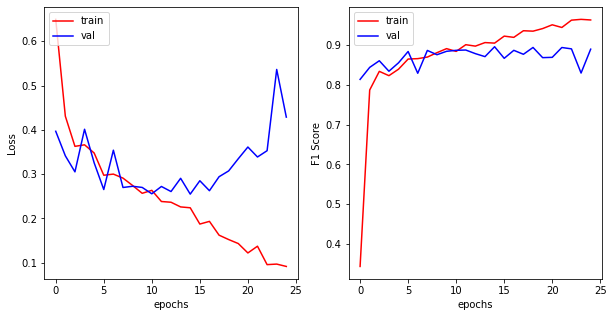

In [18]:
plot_learning_curve(history_model.history['loss'], history_model.history['val_loss'], 
                    history_model.history['f1_score'], history_model.history['val_f1_score'], 
                    metric_name='F1 Score')


The model shows a high F1 score and low loss on training data as number of epochs increase. On the other hand, for validation data as the epochs increase the loss increases and F1 score decreases. This is a sign of over fitting of the training data. We will apply regularization in order to minimize the effect of over fitting.

## Regularization <a id='reg'></a>

We will use L2 regularization with a lambda value of 0.01 on our model as the baseline model was over-fitting as a lower lambda value is generally good for fixing overfitting because it reduces the strength of the regularization term in the loss function.

Epoch 1/25
186/186 [==============================] - 16s 81ms/step - loss: 1.0854 - f1_score: 0.0913 - val_loss: 0.6949 - val_f1_score: 0.0000e+00
Epoch 2/25
186/186 [==============================] - 15s 79ms/step - loss: 0.6884 - f1_score: 0.0850 - val_loss: 0.6854 - val_f1_score: 0.0000e+00
Epoch 3/25
186/186 [==============================] - 15s 78ms/step - loss: 0.6824 - f1_score: 0.0000e+00 - val_loss: 0.6776 - val_f1_score: 0.0000e+00
Epoch 4/25
186/186 [==============================] - 15s 78ms/step - loss: 0.6804 - f1_score: 0.0000e+00 - val_loss: 0.6771 - val_f1_score: 0.0000e+00
Epoch 5/25
186/186 [==============================] - 15s 78ms/step - loss: 0.6804 - f1_score: 0.0000e+00 - val_loss: 0.6776 - val_f1_score: 0.0000e+00
Epoch 6/25
186/186 [==============================] - 15s 79ms/step - loss: 0.6800 - f1_score: 0.0000e+00 - val_loss: 0.6771 - val_f1_score: 0.0000e+00
Epoch 7/25
186/186 [==============================] - 14s 78ms/step - loss: 0.6798 - f1_score: 0

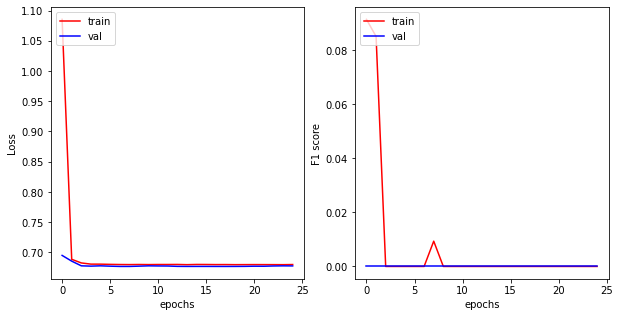

In [19]:
reg_lambda = 0.01

model_reg2 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

model_reg2.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[F1Score()])

logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
history_model_reg2 = model_reg2.fit(train_generator, epochs=25, validation_data=validation_generator, callbacks=[tensorboard_callback])

plot_learning_curve(history_model_reg2.history['loss'], history_model_reg2.history['val_loss'], 
                    history_model_reg2.history['f1_score'], history_model_reg2.history['val_f1_score'], 
                    metric_name='F1 score')

The lambda value of 0.01 adversely affected the model. The F1 score for validation data goes down to 0 which is not ideal for a good CNN. I will decrease the lambda value and fit the model to mimize overfitting. 

Epoch 1/25
186/186 [==============================] - 16s 80ms/step - loss: 0.6205 - f1_score: 0.6216 - val_loss: 0.5955 - val_f1_score: 0.7753
Epoch 2/25
186/186 [==============================] - 15s 79ms/step - loss: 0.4488 - f1_score: 0.7963 - val_loss: 0.4107 - val_f1_score: 0.8093
Epoch 3/25
186/186 [==============================] - 15s 78ms/step - loss: 0.3962 - f1_score: 0.8271 - val_loss: 0.3657 - val_f1_score: 0.8483
Epoch 4/25
186/186 [==============================] - 15s 78ms/step - loss: 0.3602 - f1_score: 0.8469 - val_loss: 0.3894 - val_f1_score: 0.8318
Epoch 5/25
186/186 [==============================] - 15s 79ms/step - loss: 0.3627 - f1_score: 0.8409 - val_loss: 0.3469 - val_f1_score: 0.8548
Epoch 6/25
186/186 [==============================] - 15s 81ms/step - loss: 0.3372 - f1_score: 0.8579 - val_loss: 0.4181 - val_f1_score: 0.8214
Epoch 7/25
186/186 [==============================] - 15s 80ms/step - loss: 0.3391 - f1_score: 0.8546 - val_loss: 0.3141 - val_f1_score:

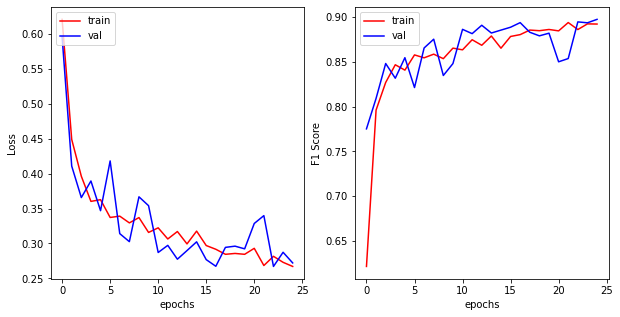

In [20]:
reg_lambda = 0.001

model_reg = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

model_reg.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[F1Score()])

logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
history_model_reg = model_reg.fit(train_generator, epochs=25, validation_data=validation_generator, callbacks=[tensorboard_callback])

plot_learning_curve(history_model_reg.history['loss'], history_model_reg.history['val_loss'], 
                    history_model_reg.history['f1_score'], history_model_reg.history['val_f1_score'], 
                    metric_name='F1 Score')

Using a lambda value of 0.001 has improved the performance of the model. The model does not have any over-fitting and the F1 score for validation data has increased to around 90% and a loss of about 0.25. 

Next, we will add a dropout layer as it would help in preventing any overfitting by reducing the complexity of the model and preventing it from memorizing the training data too closely. This would force the model to learn more robust features that are useful for making predictions, rather than relying too heavily on a small number of highly influential neurons.

Epoch 1/25
186/186 [==============================] - 16s 78ms/step - loss: 0.7206 - f1_score: 0.3399 - val_loss: 0.5995 - val_f1_score: 0.7554
Epoch 2/25
186/186 [==============================] - 14s 76ms/step - loss: 0.4766 - f1_score: 0.7674 - val_loss: 0.3620 - val_f1_score: 0.8443
Epoch 3/25
186/186 [==============================] - 15s 80ms/step - loss: 0.3801 - f1_score: 0.8359 - val_loss: 0.3317 - val_f1_score: 0.8580
Epoch 4/25
186/186 [==============================] - 14s 76ms/step - loss: 0.3602 - f1_score: 0.8494 - val_loss: 0.3856 - val_f1_score: 0.8223
Epoch 5/25
186/186 [==============================] - 14s 77ms/step - loss: 0.3622 - f1_score: 0.8468 - val_loss: 0.3617 - val_f1_score: 0.8479
Epoch 6/25
186/186 [==============================] - 15s 78ms/step - loss: 0.3799 - f1_score: 0.8331 - val_loss: 0.3289 - val_f1_score: 0.8609
Epoch 7/25
186/186 [==============================] - 15s 78ms/step - loss: 0.3614 - f1_score: 0.8465 - val_loss: 0.3178 - val_f1_score:

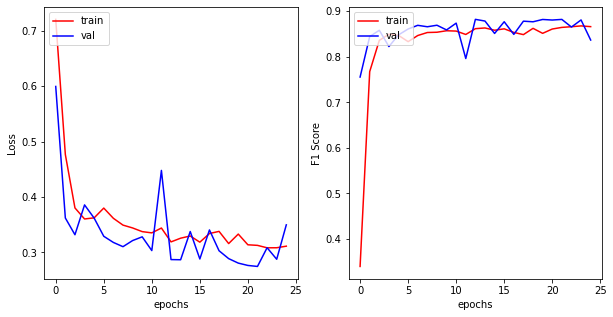

In [21]:
reg_lambda = 0.001

model_reg_drop = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

model_reg_drop.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[F1Score()])

logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
history_model_reg_drop = model_reg_drop.fit(train_generator, epochs=25, validation_data=validation_generator, callbacks=[tensorboard_callback])

plot_learning_curve(history_model_reg_drop.history['loss'], history_model_reg_drop.history['val_loss'], 
                    history_model_reg_drop.history['f1_score'], history_model_reg_drop.history['val_f1_score'], 
                    metric_name='F1 Score')

Adding the dropout layer did not improve the mode. The loss is around 0.3. There is a signifacnt increase in loss around 13 epochs. The f1 score is less than 90% which means it is less efficient than 'model_reg'.

Next, we will try increasing the number of layers. For this, we will take the regularization with 0.001 lambda value and add another convolutional layer to see if there are any more improvements to the CNN.

Epoch 1/25
186/186 [==============================] - 18s 87ms/step - loss: 0.8029 - f1_score: 0.0743 - val_loss: 0.7140 - val_f1_score: 0.0000e+00
Epoch 2/25
186/186 [==============================] - 15s 83ms/step - loss: 0.7034 - f1_score: 0.0416 - val_loss: 0.6909 - val_f1_score: 0.0000e+00
Epoch 3/25
186/186 [==============================] - 16s 83ms/step - loss: 0.6900 - f1_score: 0.0000e+00 - val_loss: 0.6837 - val_f1_score: 0.0000e+00
Epoch 4/25
186/186 [==============================] - 16s 83ms/step - loss: 0.6853 - f1_score: 0.0000e+00 - val_loss: 0.6810 - val_f1_score: 0.0000e+00
Epoch 5/25
186/186 [==============================] - 15s 82ms/step - loss: 0.6833 - f1_score: 0.0000e+00 - val_loss: 0.6792 - val_f1_score: 0.0000e+00
Epoch 6/25
186/186 [==============================] - 15s 79ms/step - loss: 0.6818 - f1_score: 0.0000e+00 - val_loss: 0.6788 - val_f1_score: 0.0000e+00
Epoch 7/25
186/186 [==============================] - 15s 82ms/step - loss: 0.6811 - f1_score: 0

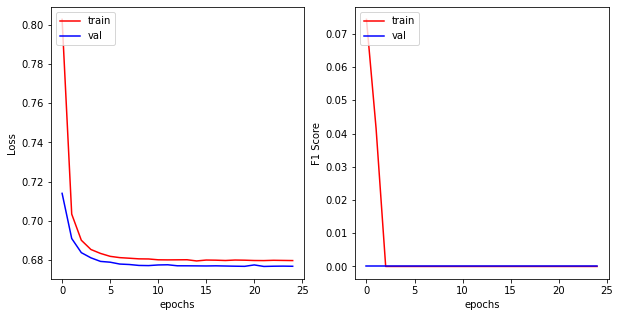

In [22]:
reg_lambda = 0.001

model_reg3 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 4
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

model_reg3.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[F1Score()])

logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
history_model_reg3 = model_reg3.fit(train_generator, epochs=25, validation_data=validation_generator, callbacks=[tensorboard_callback])

plot_learning_curve(history_model_reg3.history['loss'], history_model_reg3.history['val_loss'], 
                    history_model_reg3.history['f1_score'], history_model_reg3.history['val_f1_score'], 
                    metric_name='F1 Score')

Adding a new layer does not significantly improve the model. It decreases the model f1 score around 13 epochs. In fact it gave similar results to the graphs we got from the lambda value of 0.01.

Next, we will try increasing the batch size to 64 and fit it with reguralization to see if it will improve the model.

In [23]:
# Code taken from Week08 lab
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 64

train_generator2 = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="ImgPath",
        y_col="isCancerous",
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator2 = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="ImgPath",
        y_col="isCancerous",
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 2 classes.
Found 1979 validated image filenames belonging to 2 classes.


Epoch 1/25
93/93 [==============================] - ETA: 0s - loss: 0.7347 - f1_score: 0.4893

C:\Users\penus\anaconda3\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


93/93 [==============================] - 14s 141ms/step - loss: 0.7347 - f1_score: 0.4893 - val_loss: 0.5987 - val_f1_score: 0.6385
Epoch 2/25
93/93 [==============================] - 13s 135ms/step - loss: 0.4709 - f1_score: 0.7786 - val_loss: 0.3396 - val_f1_score: 0.8744
Epoch 3/25
93/93 [==============================] - 12s 134ms/step - loss: 0.3704 - f1_score: 0.8528 - val_loss: 0.3957 - val_f1_score: 0.8319
Epoch 4/25
93/93 [==============================] - 12s 134ms/step - loss: 0.3450 - f1_score: 0.8653 - val_loss: 0.3770 - val_f1_score: 0.8378
Epoch 5/25
93/93 [==============================] - 13s 138ms/step - loss: 0.3434 - f1_score: 0.8643 - val_loss: 0.4072 - val_f1_score: 0.8217
Epoch 6/25
93/93 [==============================] - 13s 137ms/step - loss: 0.3318 - f1_score: 0.8643 - val_loss: 0.2887 - val_f1_score: 0.8885
Epoch 7/25
93/93 [==============================] - 12s 134ms/step - loss: 0.3243 - f1_score: 0.8716 - val_loss: 0.2918 - val_f1_score: 0.8873
Epoch 8/25

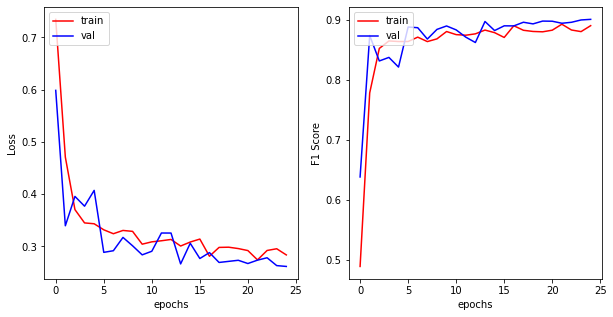

In [25]:
reg_lambda = 0.001

model2 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

model2.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[F1Score()])

logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
history_model2 = model2.fit(train_generator2, epochs=25, validation_data=validation_generator2, callbacks=[tensorboard_callback])

plot_learning_curve(history_model2.history['loss'], history_model2.history['val_loss'], 
                    history_model2.history['f1_score'], history_model2.history['val_f1_score'], 
                    metric_name='F1 Score')

This shows the almost the same results as the model with 32 batches and 0.001 lambda for reguralization as it as a f1 score of almost 90% but the loss is higher in this model around 0.3. 

Therefore, as our final model we will be using the model with 32 batches and 0.001 lambda for reguralization as it showed the least values for loss and high f1 score. This was stored under the variable 'model_reg'.

## Testing <a id='test'></a>

Finally we will use our final model and test it on our test data. To do this we will first create a data geenrator for the test data.

In [26]:
test_data['isCancerous'] = test_data['isCancerous'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="ImgPath",
        y_col="isCancerous",
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 2 classes.


Now we will evaluate our model on the test data generator.

In [28]:
model_reg.evaluate(test_generator)

62/62 [==============================] - 1s 19ms/step - loss: 0.2674 - f1_score: 0.9057


[0.26740750670433044, 0.9056701064109802]

Our model gives us a loss of 0.3 and a f1 score of 91%.